In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch, numpy as np
import sys
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer, BertModel
from datasets import Dataset, load_dataset
import pandas as pd 
import math
import numpy as np
import torch, numpy as np
from tqdm.auto import tqdm
from sklearn.cluster import DBSCAN
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from typing import Literal, Sequence, Any
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (normalized_mutual_info_score,
                             adjusted_mutual_info_score,
                             v_measure_score,
                             fowlkes_mallows_score,
                             silhouette_score,
                             adjusted_rand_score)


In [2]:
OUTPUT_DIR_GMAP = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/GMAP"
OUTPUT_DIR_MOBILE = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE"
OUTPUT_DIR_MOBILE_UNTRAINED = f"{OUTPUT_DIR_MOBILE}/untrained_model"
OUTPUT_DIR_MOBILE_SIMPLE_BERT = f"{OUTPUT_DIR_MOBILE}/simple_bert_model"
OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER_UNTRAINED = f"{OUTPUT_DIR_MOBILE}/normal_tokenizer_untrained/"
OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER = f"{OUTPUT_DIR_MOBILE}/normal_tokenizer/"
OUTPUT_DIR = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/"
OUTPUT_DIR_NORMAL_TOKENIZER = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_regular_tokenizer"
OUTPUT_DIR_SPECIES_LEVEL = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_species_level/"
DATA_DIR = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/sentences_with_labels"
TSV_FILE_GMAP = f"{DATA_DIR}/gmap_sentences_and_labels.tsv"
TSV_FILE_MOBILE = f"{DATA_DIR}/mobile_sentences_and_labels.tsv"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create sample-level embeddings
def cls_embed(texts, model, tokenizer, batch_size=32):
    model.eval()
    embs = []
    device = next(model.parameters()).device  # Get model's device

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, max_length=512,
                        padding=True, return_tensors="pt").to(device)  # Move to same device as model
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
        embs.append(out.hidden_states[-1][:,0].cpu())   # Move back to CPU for storage
    return torch.cat(embs, 0)

In [4]:
def run_tsne_no_label(embedding_file, output_file=None, perplexity=30):
    # Load embeddings
    embeddings = np.load(embedding_file)
    print(f"Loaded embeddings: {embeddings.shape}")
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(embeddings)
    
    # Create DataFrame for plotting
    tsne_df = pd.DataFrame({
        'TSNE-1': tsne_result[:, 0],
        'TSNE-2': tsne_result[:, 1]
    })
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_df['TSNE-1'], tsne_df['TSNE-2'], s=60, alpha=0.7)
    plt.title('t-SNE of Embeddings')
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save if output file specified
    if output_file:
        plt.savefig(output_file)
        print(f"Saved t-SNE plot to {output_file}")
    
    plt.show()
    
    return tsne_result, tsne_df

In [5]:
def load_and_prepare_data(tsv_file_path, text_column='Sentence', metadata_columns=['Filename', 'Age', 'Sample_type']):
    """
    Load TSV file and prepare sentences and metadata for embedding generation.
    
    Args:
        tsv_file_path (str): Path to the TSV file
        text_column (str): Name of the column containing text data
        metadata_columns (list): List of column names to extract as metadata
    
    Returns:
        tuple: (sentences_list, metadata_dataframe)
    """
    # Read the TSV file
    print(f"Reading TSV file: {tsv_file_path}")
    df = pd.read_csv(tsv_file_path, sep='\t')
    print(f"Loaded {len(df)} samples")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check if required columns exist
    if text_column not in df.columns:
        raise ValueError(f"Text column '{text_column}' not found in the TSV file")
    
    missing_metadata_cols = [col for col in metadata_columns if col not in df.columns]
    if missing_metadata_cols:
        print(f"Warning: Missing metadata columns: {missing_metadata_cols}")
        metadata_columns = [col for col in metadata_columns if col in df.columns]
        print(f"Using available metadata columns: {metadata_columns}")
    
    # Display first few rows to verify data
    print("\nFirst 3 samples:")
    display_columns = [text_column] + [col for col in metadata_columns if col in df.columns]
    print(df[display_columns].head(3))
    
    # Remove rows with NaN sentences but keep the metadata aligned
    df_clean = df.dropna(subset=[text_column]).reset_index(drop=True)
    print(f"\nTotal samples after removing NaN from '{text_column}': {len(df_clean)}")
    
    # Extract sentences and metadata
    sentences = df_clean[text_column].tolist()
    metadata = df_clean[metadata_columns].copy()
    
    # Add sample ID (row index after cleaning)
    metadata['sample_id'] = range(len(df_clean))
    
    print(f"Sentences: {len(sentences)}")
    print(f"Metadata shape: {metadata.shape}")
    
    return sentences, metadata

In [6]:
def generate_and_save_embeddings(sentences, metadata, model, tokenizer, output_dir, 
                                batch_size=32, file_prefix="sample"):
    """
    Generate embeddings from sentences and save them along with metadata.
    
    Args:
        sentences (list): List of text strings to embed
        metadata (pd.DataFrame): DataFrame containing metadata for each sentence
        model: The transformer model for generating embeddings
        tokenizer: The tokenizer corresponding to the model
        output_dir (str): Directory path where files will be saved
        batch_size (int): Batch size for embedding generation
        file_prefix (str): Prefix for output filenames
    
    Returns:
        torch.Tensor: The generated embeddings tensor
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Move model to GPU if available
    model = model.to(device)
    
    # Verify model is on GPU
    print(f"Model is on: {next(model.parameters()).device}")
    
    # Generate embeddings
    print("\nGenerating embeddings...")
    sample_embs = cls_embed(sentences, model, tokenizer, batch_size=batch_size)
    print(f"Embeddings shape: {sample_embs.shape}")
    
    # Verify alignment
    assert sample_embs.shape[0] == len(metadata), f"Mismatch: {sample_embs.shape[0]} embeddings vs {len(metadata)} metadata rows"
    
    # Save embeddings and metadata
    print("\nSaving embeddings and metadata...")
    embeddings_path = f"{output_dir}/{file_prefix}_embeddings.npy"
    metadata_path = f"{output_dir}/{file_prefix}_metadata.csv"
    combined_path = f"{output_dir}/{file_prefix}_embeddings_with_metadata.npy"
    
    # Save embeddings only
    np.save(embeddings_path, sample_embs.numpy())
    
    # Save metadata only
    metadata.to_csv(metadata_path, index=False)
    
    # Save combined data structure
    print("Creating combined data structure...")
    combined_data = {
        'embeddings': sample_embs.numpy(),
        'metadata': metadata.to_dict('records')  # Convert to list of dictionaries
    }
    np.save(combined_path, combined_data)
    
    print("Done! Files saved:")
    print(f"- {embeddings_path} (embeddings only)")
    print(f"- {metadata_path} (metadata only)")
    print(f"- {combined_path} (combined)")
    
    return sample_embs

In [7]:
def run_tsne(embedding_file, label_file, title, label_column='', output_file=None, perplexity=30):
    # Load embeddings
    embeddings = np.load(embedding_file)
    print(f"Loaded embeddings: {embeddings.shape}")
    
    # Load labels (metadata)
    labels_df = pd.read_csv(label_file)
    labels = labels_df[label_column].values
    print(f"Loaded labels: {len(labels)}")
    print(f"Unique values: {np.unique(labels)}")
    
    assert embeddings.shape[0] == len(labels), "Mismatch between embeddings and labels count."
    
    # Run t-SNE
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(embeddings)
    
    # Create DataFrame for plotting
    tsne_df = pd.DataFrame({
        'TSNE-1': tsne_result[:, 0],
        'TSNE-2': tsne_result[:, 1],
        'label': labels
    })
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Check if Age values are numeric or categorical
    unique_values = np.unique(labels)
    if len(unique_values) <= 10:  # Treat as categorical if few unique values
        # Create a color map for categorical data
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_values)))
        
        for i, age in enumerate(unique_values):
            mask = labels == age
            plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                       c=[colors[i]], label=f'label {age}', s=60, alpha=0.7)
        
        plt.legend(title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:  # Treat as continuous if many unique values
        scatter = plt.scatter(tsne_df['TSNE-1'], tsne_df['TSNE-2'], 
                            c=tsne_df[label_column], cmap='viridis', s=60, alpha=0.7)
        plt.colorbar(scatter, label=label_column)
    
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    
    # Save plot if specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved t-SNE plot to {output_file}")
    
    plt.show()
    
    return tsne_df

In [8]:
### GMAP ###

In [9]:
sentences, metadata = load_and_prepare_data(TSV_FILE_GMAP)

Reading TSV file: /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/sentences_with_labels/gmap_sentences_and_labels.tsv
Loaded 739 samples
Columns: ['Filename', 'Sentence', 'Patient', 'Location', 'Lifestyle', 'Sample_type', 'Age']

First 3 samples:
                                            Sentence             Filename  \
0  Bacteroidales Tannerellaceae Parabacteroides P...    sub.110.0_initial   
1  Lactobacillales Streptococcaceae Streptococcus...  sub.110.2_one_month   
2  Enterobacterales Enterobacteriaceae Klebsiella...   sub.110.3_twomonth   

    Age Sample_type  
0  0-1M  infant_gut  
1  0-1M  infant_gut  
2  1-4M  infant_gut  

Total samples after removing NaN from 'Sentence': 739
Sentences: 739
Metadata shape: (739, 4)


Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/GMAP/sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/GMAP/sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/GMAP/sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['0-1M' 'adult']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/GMAP/tsne_age_plot_gmap_fine_tuned.png


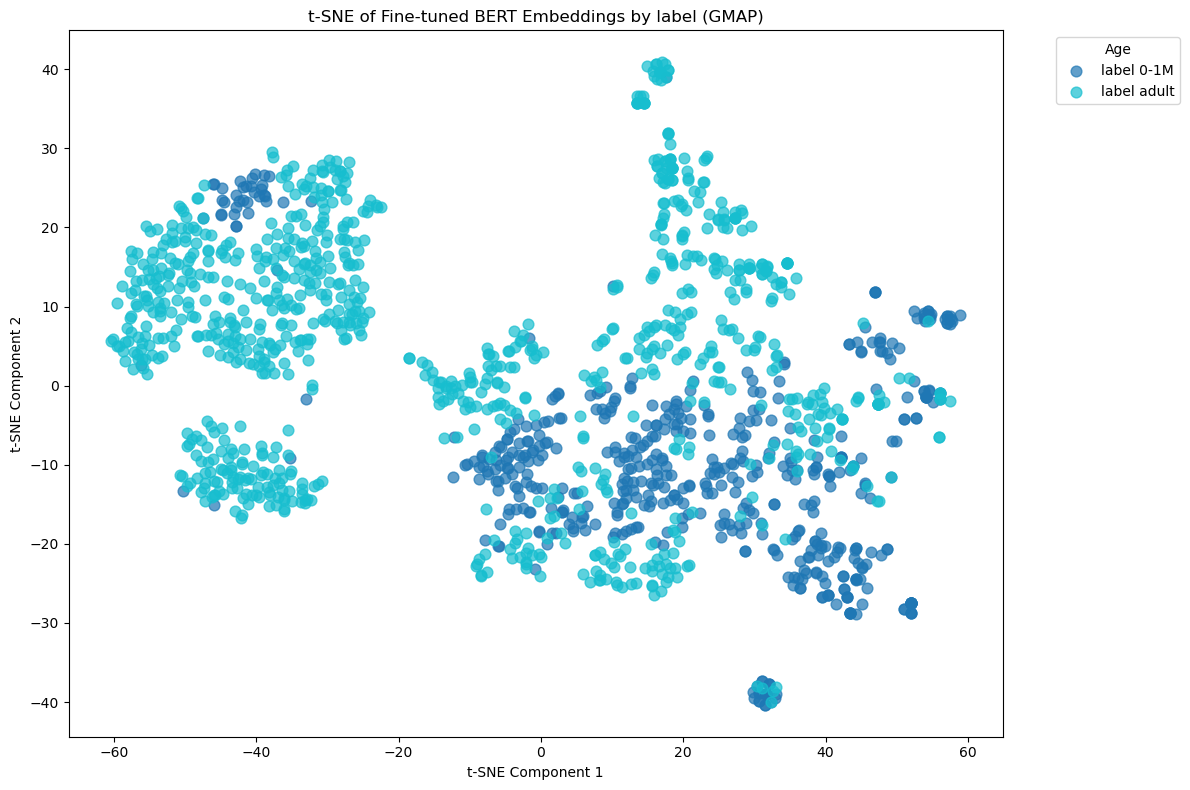

In [17]:
# Fine-tuned model

model = AutoModelForMaskedLM.from_pretrained(f"{OUTPUT_DIR}/model")
tokenizer = AutoTokenizer.from_pretrained(f"{OUTPUT_DIR}/tokenizer")

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_GMAP
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_GMAP}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_GMAP}/sample_metadata.csv",
    title='t-SNE of Fine-tuned BERT Embeddings by label (GMAP)',
    label_column='Age',
    output_file=f"{OUTPUT_DIR_GMAP}/tsne_age_plot_gmap_fine_tuned.png"
)

In [18]:
## MOBILE ##

In [19]:
sentences, metadata = load_and_prepare_data(TSV_FILE_MOBILE)

Reading TSV file: /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/sentences_with_labels/mobile_sentences_and_labels.tsv
Loaded 1509 samples
Columns: ['Filename', 'Sentence', 'Location', 'Sample_type', 'Age']

First 3 samples:
                                            Sentence  \
0  Eubacteriales Oscillospiraceae Neobittarella N...   
1  Bifidobacteriales Bifidobacteriaceae Gardnerel...   
2  Lactobacillales Lactobacillaceae Lactobacillus...   

                       Filename    Age Sample_type  
0  YASLAB-001-MOB-017-Rec_R.txt  adult   adult_gut  
1  YASLAB-001-MOB-017-vag_R.txt  adult     vaginal  
2  YASLAB-001-MOB-019-vag_R.txt  adult     vaginal  

Total samples after removing NaN from 'Sentence': 1509
Sentences: 1509
Metadata shape: (1509, 4)


Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/tsne_sample_type_mobile_fine_tuned_plot.png


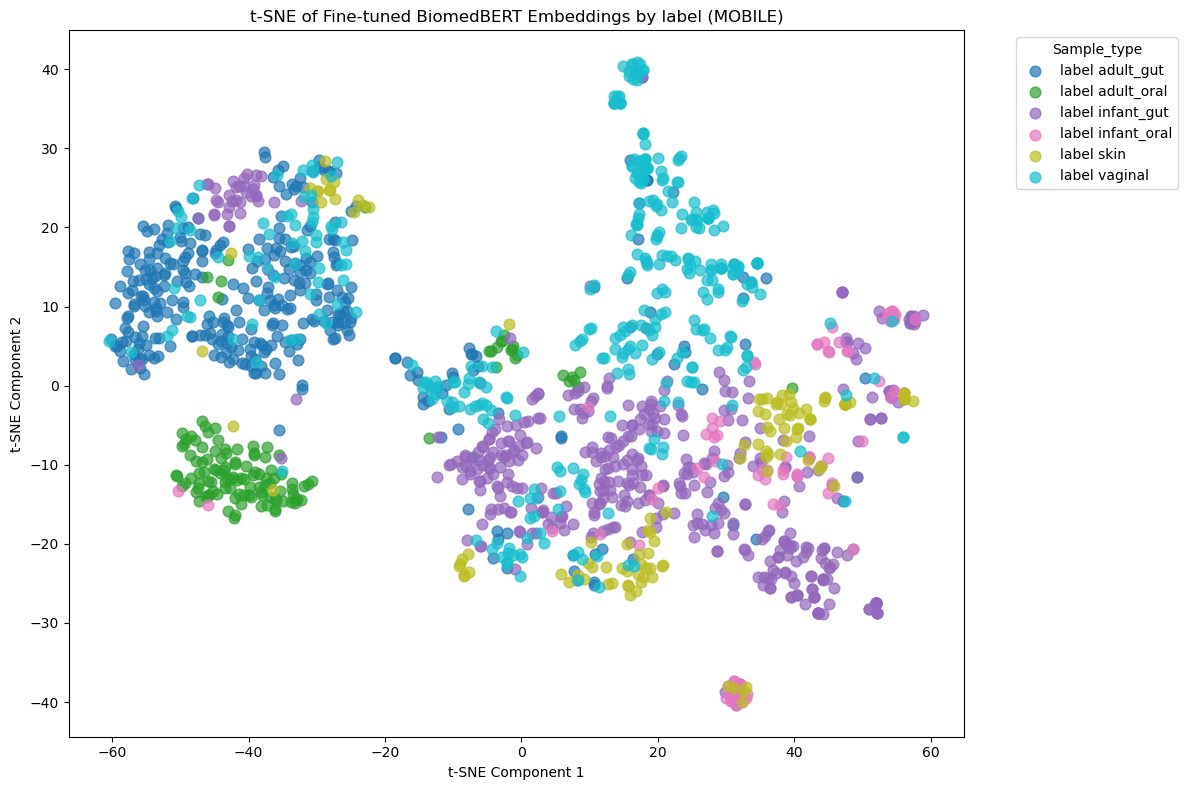

In [20]:
# Fine-tuned model

model = AutoModelForMaskedLM.from_pretrained(f"{OUTPUT_DIR}/model")
tokenizer = AutoTokenizer.from_pretrained(f"{OUTPUT_DIR}/tokenizer")

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_MOBILE
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_MOBILE}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_MOBILE}/sample_metadata.csv",
    title='t-SNE of Fine-tuned BiomedBERT Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_MOBILE}/tsne_sample_type_mobile_fine_tuned_plot.png"
)

Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/untrained_model/sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/untrained_model/sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/untrained_model/sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/untrained_model/tsne_sample_type_biomed_plot.png


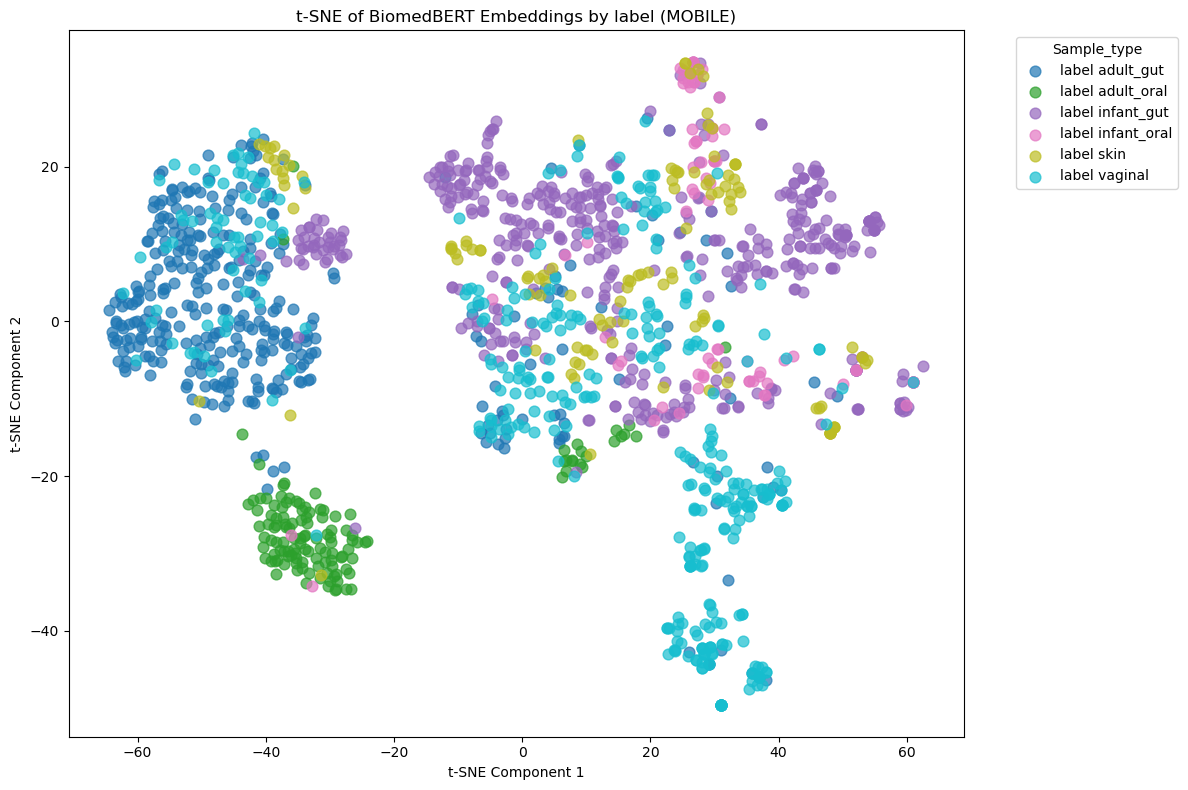

In [21]:
# BiodmedBERT model

MODEL_NAME = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_MOBILE_UNTRAINED
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_MOBILE_UNTRAINED}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_MOBILE_UNTRAINED}/sample_metadata.csv",
    title='t-SNE of BiomedBERT Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_MOBILE_UNTRAINED}/tsne_sample_type_biomed_plot.png"
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/simple_bert_model/sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/simple_bert_model/sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/simple_bert_model/sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/simple_bert_model/tsne_sample_type_bert_plot.png


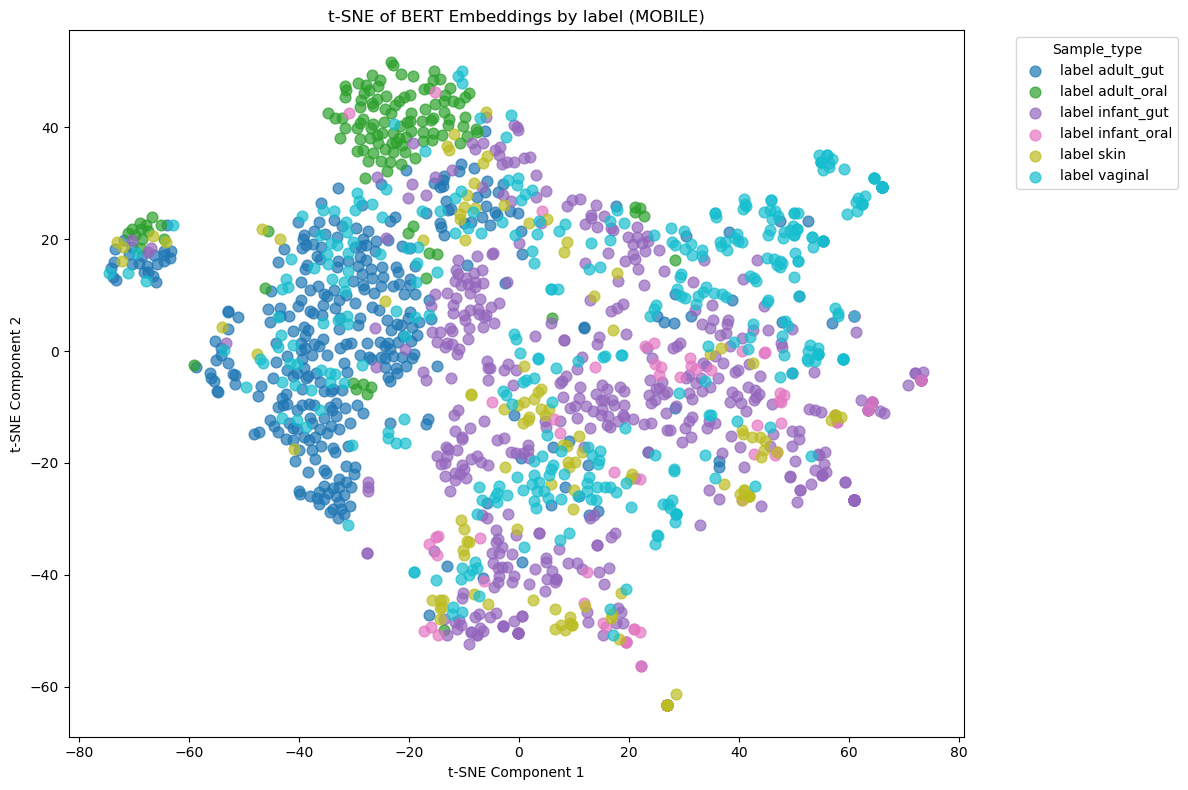

In [22]:
# BERT model

MODEL_NAME = 'bert-base-uncased'
model = BertModel.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_MOBILE_SIMPLE_BERT
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_MOBILE_SIMPLE_BERT}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_MOBILE_SIMPLE_BERT}/sample_metadata.csv",
    title='t-SNE of BERT Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_MOBILE_SIMPLE_BERT}/tsne_sample_type_bert_plot.png"
)


Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_species_level//sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_species_level//sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_species_level//sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model_species_level//tsne_sample_type_species_level_plot.png


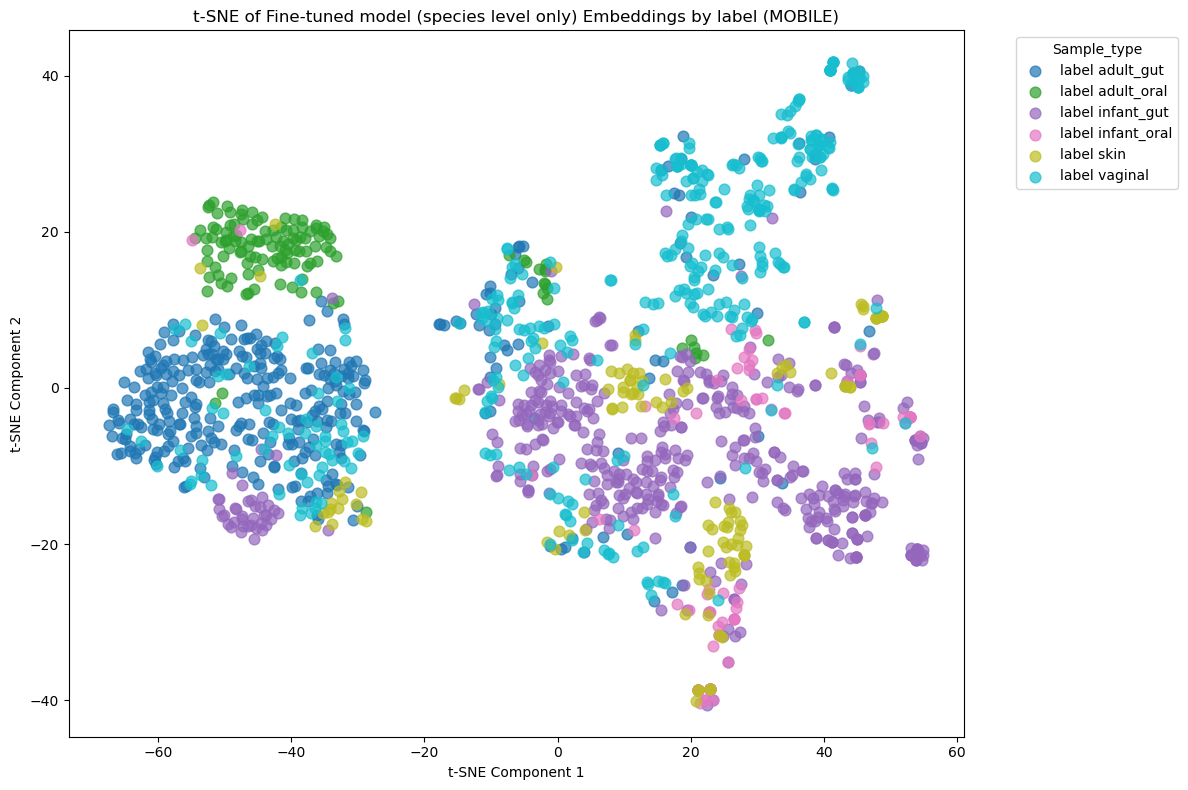

In [23]:
# Species level fine-tuned model

model = AutoModelForMaskedLM.from_pretrained(f"{OUTPUT_DIR_SPECIES_LEVEL}/model")
tokenizer = AutoTokenizer.from_pretrained(f"{OUTPUT_DIR_SPECIES_LEVEL}/tokenizer")

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_SPECIES_LEVEL
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_SPECIES_LEVEL}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_SPECIES_LEVEL}/sample_metadata.csv",
    title='t-SNE of Fine-tuned model (species level only) Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_SPECIES_LEVEL}/tsne_sample_type_species_level_plot.png"
)

Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer_untrained//sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer_untrained//sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer_untrained//sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer_untrained//tsne_sample_type_biomed_regular_token_plot.png


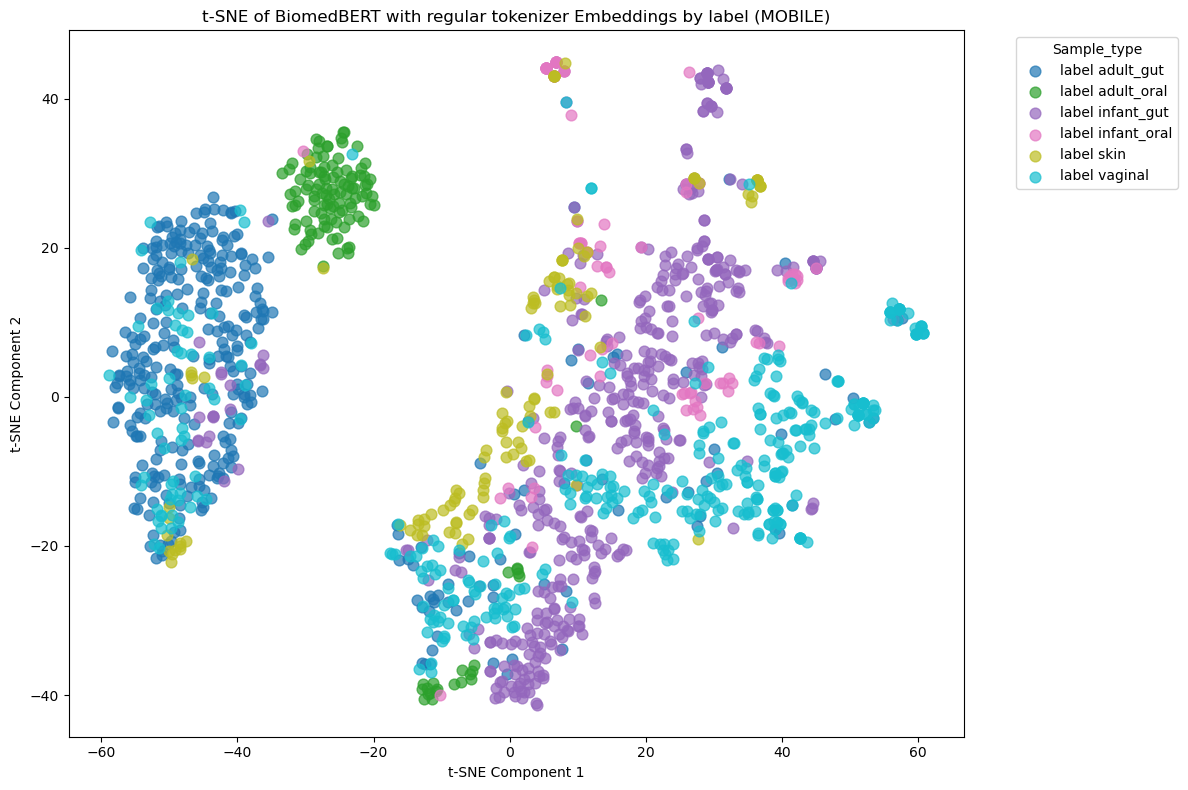

In [24]:
# BiomedBERT model with regular tokenizer

MODEL_NAME = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER_UNTRAINED
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER_UNTRAINED}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER_UNTRAINED}/sample_metadata.csv",
    title='t-SNE of BiomedBERT with regular tokenizer Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER_UNTRAINED}/tsne_sample_type_biomed_regular_token_plot.png"
)

Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1509, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer//sample_embeddings.npy (embeddings only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer//sample_metadata.csv (metadata only)
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer//sample_embeddings_with_metadata.npy (combined)
Loaded embeddings: (1509, 768)
Loaded labels: 1509
Unique values: ['adult_gut' 'adult_oral' 'infant_gut' 'infant_oral' 'skin' 'vaginal']
Running t-SNE...
Saved t-SNE plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/normal_tokenizer//tsne_sample_type_fine_tuned_regular_token_plot.png


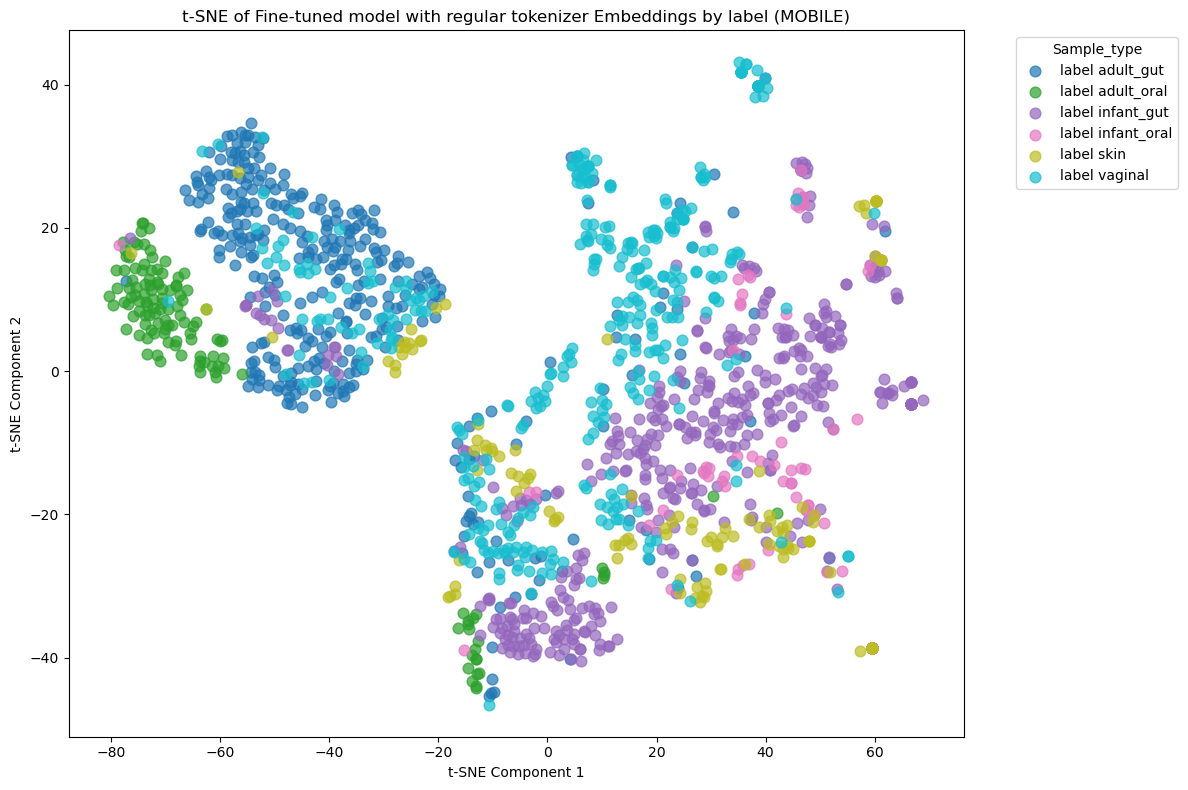

In [25]:
# Fine-tuned model with regular tokenizer

model = AutoModelForMaskedLM.from_pretrained(f"{OUTPUT_DIR_NORMAL_TOKENIZER}/model")
tokenizer = AutoTokenizer.from_pretrained(f"{OUTPUT_DIR_NORMAL_TOKENIZER}/tokenizer")

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER
)

tsne_results = run_tsne(
    embedding_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER}/sample_embeddings.npy",
    label_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER}/sample_metadata.csv",
    title='t-SNE of Fine-tuned model with regular tokenizer Embeddings by label (MOBILE)',
    label_column='Sample_type',
    output_file=f"{OUTPUT_DIR_MOBILE_NORMAL_TOKENIZER}/tsne_sample_type_fine_tuned_regular_token_plot.png"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform

def run_pcoa(embedding_file, label_file, label_column='', output_file=None, metric='euclidean'):
    # Load embeddings
    embeddings = np.load(embedding_file)
    print(f"Loaded embeddings: {embeddings.shape}")

    # Load labels
    labels_df = pd.read_csv(label_file)
    labels = labels_df[label_column].values
    print(f"Loaded labels: {len(labels)}")
    print(f"Unique values: {np.unique(labels)}")

    assert embeddings.shape[0] == len(labels), "Mismatch between embeddings and labels count."

    # Compute distance matrix
    print(f"Computing {metric} distance matrix...")
    distance_matrix = squareform(pdist(embeddings, metric=metric))

    # Run PCoA
    print("Running PCoA...")
    pcoa_results = pcoa(distance_matrix)

    # Take first two coordinates
    pcoa_coords = pcoa_results.samples.iloc[:, :2].values

    # Create DataFrame for plotting
    pcoa_df = pd.DataFrame({
        'PCoA1': pcoa_coords[:, 0],
        'PCoA2': pcoa_coords[:, 1],
        'label': labels
    })

    # Plot
    plt.figure(figsize=(12, 8))

    unique_values = np.unique(labels)
    if len(unique_values) <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_values)))

        for i, val in enumerate(unique_values):
            mask = labels == val
            plt.scatter(pcoa_coords[mask, 0], pcoa_coords[mask, 1],
                        c=[colors[i]], label=f'label {val}', s=60, alpha=0.7)

        plt.legend(title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        scatter = plt.scatter(pcoa_df['PCoA1'], pcoa_df['PCoA2'],
                              c=pcoa_df['label'], cmap='viridis', s=60, alpha=0.7)
        plt.colorbar(scatter, label=label_column)

    plt.title('PCoA of Embeddings by Label')
    plt.xlabel('PCoA Component 1')
    plt.ylabel('PCoA Component 2')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved PCoA plot to {output_file}")

    plt.show()

    return pcoa_df


In [ ]:
df = run_pcoa("bert_embeddings.npy", "metadata.csv", label_column="age_group")

In [26]:
def run_tsne_with_clustering(
        embedding_file: str,
        output_dir: str | None = None,
        *,
        perplexity: int = 30,
        cluster_space: Literal["tsne", "original"] = "tsne",
        n_components_gmm: int = 5,
        n_clusters_kmeans: int = 5,
        true_labels: Sequence | None = None,
):
    
    # ---------- load ----------
    embeddings = np.load(embedding_file)
    print(f"Loaded embeddings: {embeddings.shape}")

    # ---------- t-SNE (always for visualisation) ----------
    tsne = TSNE(n_components=2, random_state=42,
                perplexity=perplexity, verbose=1)
    tsne_result = tsne.fit_transform(embeddings)
    tsne_df = pd.DataFrame({"TSNE-1": tsne_result[:, 0],
                            "TSNE-2": tsne_result[:, 1]})

    # choose space for clustering
    data_for_clustering = embeddings if cluster_space == "original" else tsne_result
    print(f"Clustering in {'ORIGINAL' if cluster_space == 'original' else '2-D t-SNE'} space …")

    # ---------- GMM ----------
    gmm = GaussianMixture(n_components=n_components_gmm, random_state=42)
    gmm_labels = gmm.fit_predict(data_for_clustering)
    tsne_df["GMM_Cluster"] = gmm_labels

    # ---------- K-Means ----------
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init="auto")
    kmeans_labels = kmeans.fit_predict(data_for_clustering)
    tsne_df["KMEANS_Cluster"] = kmeans_labels

    # ---------- metrics ----------
    def safe_silhouette(coords, labels):
        return silhouette_score(coords, labels) if len(np.unique(labels)) > 1 else 0

    print("\n=== Silhouette scores (computed in clustering space) ===")
    print(f"GMM      k={n_components_gmm:2d}: {safe_silhouette(data_for_clustering, gmm_labels):.3f}")
    print(f"K-Means  k={n_clusters_kmeans:2d}: {safe_silhouette(data_for_clustering, kmeans_labels):.3f}")
    if len(np.unique(gmm_labels)) > 1 and len(np.unique(kmeans_labels)) > 1:
        print(f"ARI(GMM, K-Means)    : {adjusted_rand_score(gmm_labels, kmeans_labels):.3f}")

    if true_labels is not None:
        # factorise strings → int codes if needed
        y = np.asarray(true_labels)
        if not np.issubdtype(y.dtype, np.number):
            y, _ = pd.factorize(y)

        def show_scores(name, pred):
            print(f"\n{name} vs true labels:")
            print(f"  ARI  : {adjusted_rand_score   (y, pred):.3f}")
            print(f"  NMI  : {normalized_mutual_info_score(y, pred):.3f}")
            print(f"  AMI  : {adjusted_mutual_info_score (y, pred):.3f}")
            print(f"  V-me : {v_measure_score        (y, pred):.3f}")
            print(f"  FMI  : {fowlkes_mallows_score  (y, pred):.3f}")

        show_scores("GMM",     gmm_labels)
        show_scores("K-Means", kmeans_labels)

    # ---------- visualisation ----------
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        f"t-SNE + Clustering (fitted in {'original D-dim' if cluster_space=='original' else '2-D t-SNE'} space)",
        fontsize=14, y=1.02
    )

    axes[0].scatter(tsne_df["TSNE-1"], tsne_df["TSNE-2"],
                    s=50, alpha=.6)
    axes[0].set_title("Raw t-SNE")

    for ax, col, title in zip(
        axes[1:],
        ["GMM_Cluster", "KMEANS_Cluster"],
        [f"GMM (k={n_components_gmm})",
         f"K-Means (k={n_clusters_kmeans})"]):
        sc = ax.scatter(tsne_df["TSNE-1"], tsne_df["TSNE-2"],
                        c=tsne_df[col], s=50, alpha=.7, cmap="tab10")
        ax.set_title(title)
        plt.colorbar(sc, ax=ax, fraction=.046)

    for ax in axes:
        ax.set_xlabel("TSNE-1"); ax.set_ylabel("TSNE-2"); ax.grid(alpha=.3)

    plt.tight_layout()

    # ---------- save ----------
    if output_dir:
        fname = f"{output_dir}/tsne_clustering_{cluster_space}.png"
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {fname}")

    plt.show()
    return tsne_result, tsne_df, gmm, kmeans


Loaded embeddings: (1509, 768)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1509 samples in 0.001s...
[t-SNE] Computed neighbors for 1509 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1509
[t-SNE] Computed conditional probabilities for sample 1509 / 1509
[t-SNE] Mean sigma: 0.853775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.774132
[t-SNE] KL divergence after 1000 iterations: 0.797093
Clustering in 2-D t-SNE space …

=== Silhouette scores (computed in clustering space) ===
GMM      k= 6: 0.423
K-Means  k= 6: 0.437
ARI(GMM, K-Means)    : 0.743

GMM vs true labels:
  ARI  : 0.233
  NMI  : 0.322
  AMI  : 0.319
  V-me : 0.322
  FMI  : 0.387

K-Means vs true labels:
  ARI  : 0.188
  NMI  : 0.284
  AMI  : 0.280
  V-me : 0.284
  FMI  : 0.347
Figure saved to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/tsne_clustering_tsne.png


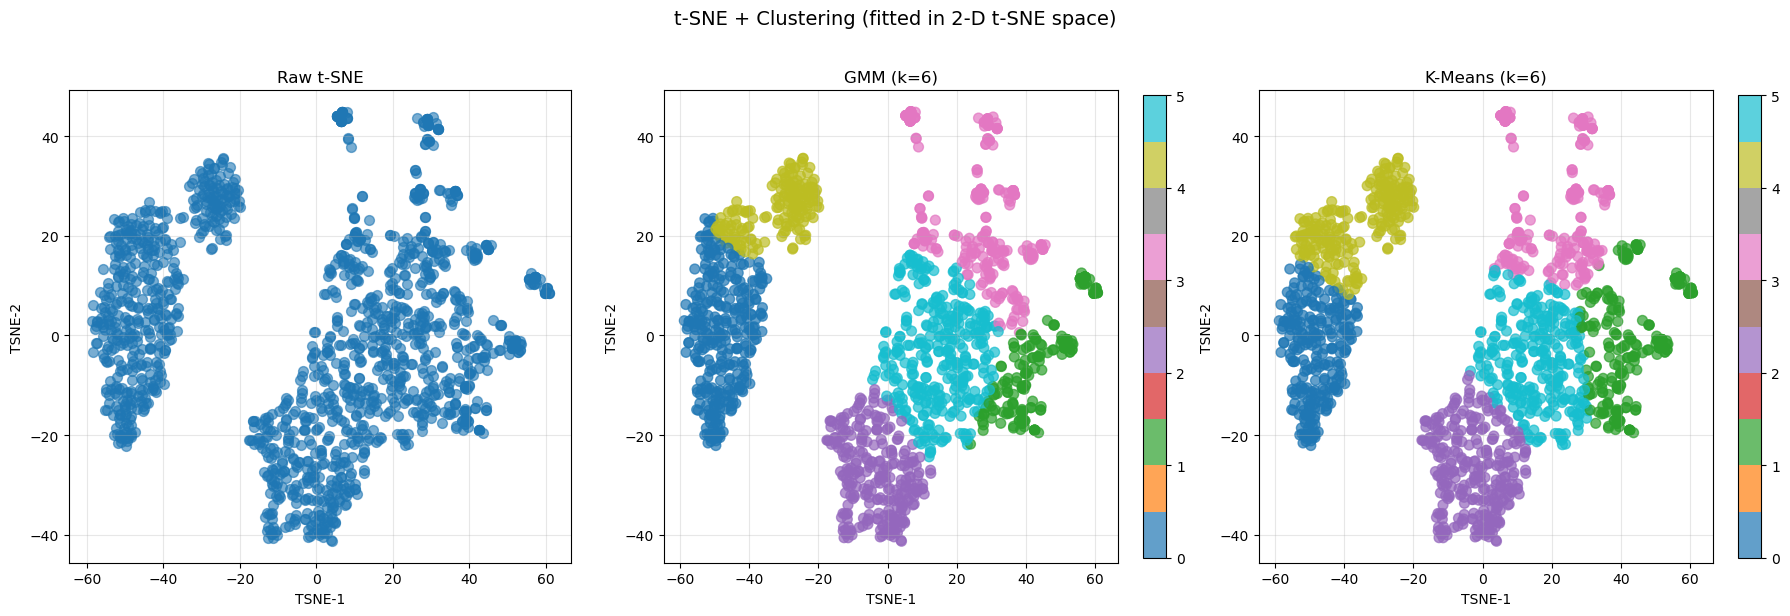

Loaded embeddings: (1509, 768)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1509 samples in 0.001s...
[t-SNE] Computed neighbors for 1509 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1509
[t-SNE] Computed conditional probabilities for sample 1509 / 1509
[t-SNE] Mean sigma: 0.853775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.774132
[t-SNE] KL divergence after 1000 iterations: 0.797093
Clustering in ORIGINAL space …

=== Silhouette scores (computed in clustering space) ===
GMM      k= 6: 0.170
K-Means  k= 6: 0.170
ARI(GMM, K-Means)    : 1.000

GMM vs true labels:
  ARI  : 0.158
  NMI  : 0.250
  AMI  : 0.247
  V-me : 0.250
  FMI  : 0.331

K-Means vs true labels:
  ARI  : 0.158
  NMI  : 0.250
  AMI  : 0.247
  V-me : 0.250
  FMI  : 0.331
Figure saved to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/MOBILE/tsne_clustering_original.png


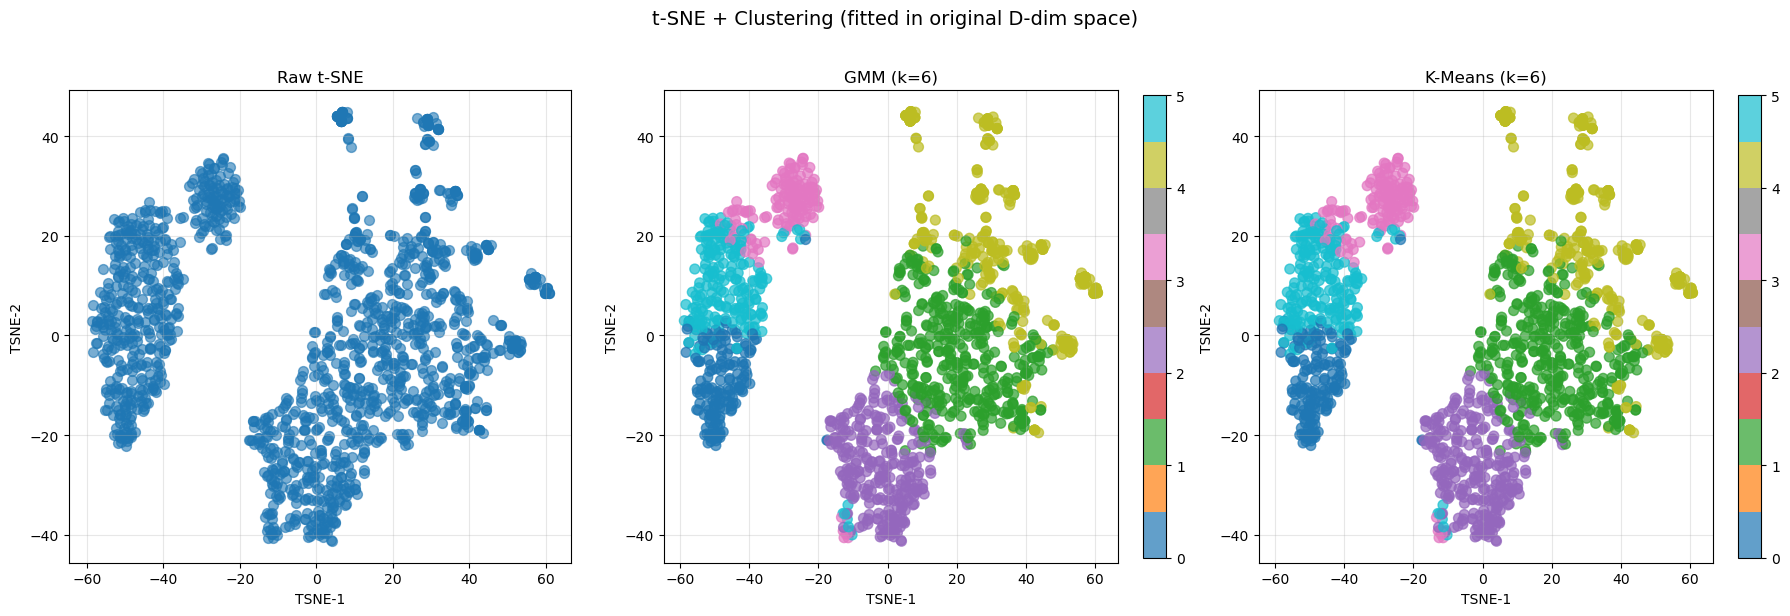

(array([[-40.050552 ,   6.3114824],
        [ 36.045166 , -15.358092 ],
        [ 44.606705 ,  -1.9673132],
        ...,
        [-52.755604 ,  16.00056  ],
        [  8.040237 ,  44.792263 ],
        [ 39.388233 ,   5.599206 ]], shape=(1509, 2), dtype=float32),
          TSNE-1     TSNE-2  GMM_Cluster  KMEANS_Cluster
 0    -40.050552   6.311482            5               5
 1     36.045166 -15.358092            1               1
 2     44.606705  -1.967313            1               1
 3     -8.115439 -23.178366            2               2
 4    -40.263630   9.040865            5               5
 ...         ...        ...          ...             ...
 1504  13.524154   6.398139            1               1
 1505 -24.037378  30.448740            3               3
 1506 -52.755604  16.000561            5               5
 1507   8.040237  44.792263            4               4
 1508  39.388233   5.599206            4               4
 
 [1509 rows x 4 columns],
 GaussianMixture(n_compon

In [27]:
labels_df = pd.read_csv(f"{OUTPUT_DIR_MOBILE}/sample_metadata.csv")
true_labels = labels_df['Sample_type']


run_tsne_with_clustering(
    f"{OUTPUT_DIR_MOBILE}/sample_embeddings.npy",
    output_dir=OUTPUT_DIR_MOBILE,
    cluster_space="tsne",
    n_components_gmm=6,
    n_clusters_kmeans=6,
    true_labels=true_labels
)


run_tsne_with_clustering(
    f"{OUTPUT_DIR_MOBILE}/sample_embeddings.npy",
    output_dir=OUTPUT_DIR_MOBILE,
    cluster_space="original",
    n_components_gmm=6,
    n_clusters_kmeans=6,
    true_labels=true_labels
)


Reading TSV file: /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/sentences_with_labels/data_for_fine_tuning.tsv
Loaded 5950 samples
Columns: ['Filename', 'Sentence', 'Location', 'Sample_type', 'Age', 'Lifestyle']

First 3 samples:
                                            Sentence          Filename  \
0  Bacteroidales Bacteroidaceae GGB28271 GGB28271...  Zeevi_ERR1110297   
1  Bacteroidales Bacteroidaceae GGB1364 GGB1364_S...  Zeevi_ERR1110298   
2  Bacteroidales Bacteroidaceae Bacteroides Bacte...  Zeevi_ERR1110299   

  Location Sample_type  
0   Israel   adult_gut  
1   Israel   adult_gut  
2   Israel   adult_gut  

Total samples after removing NaN from 'Sentence': 5950
Sentences: 5950
Metadata shape: (5950, 4)
Using device: cuda
Model is on: cuda:0

Generating embeddings...
Embeddings shape: torch.Size([1679, 768])

Saving embeddings and metadata...
Creating combined data structure...
Done! Files saved:
- /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/F

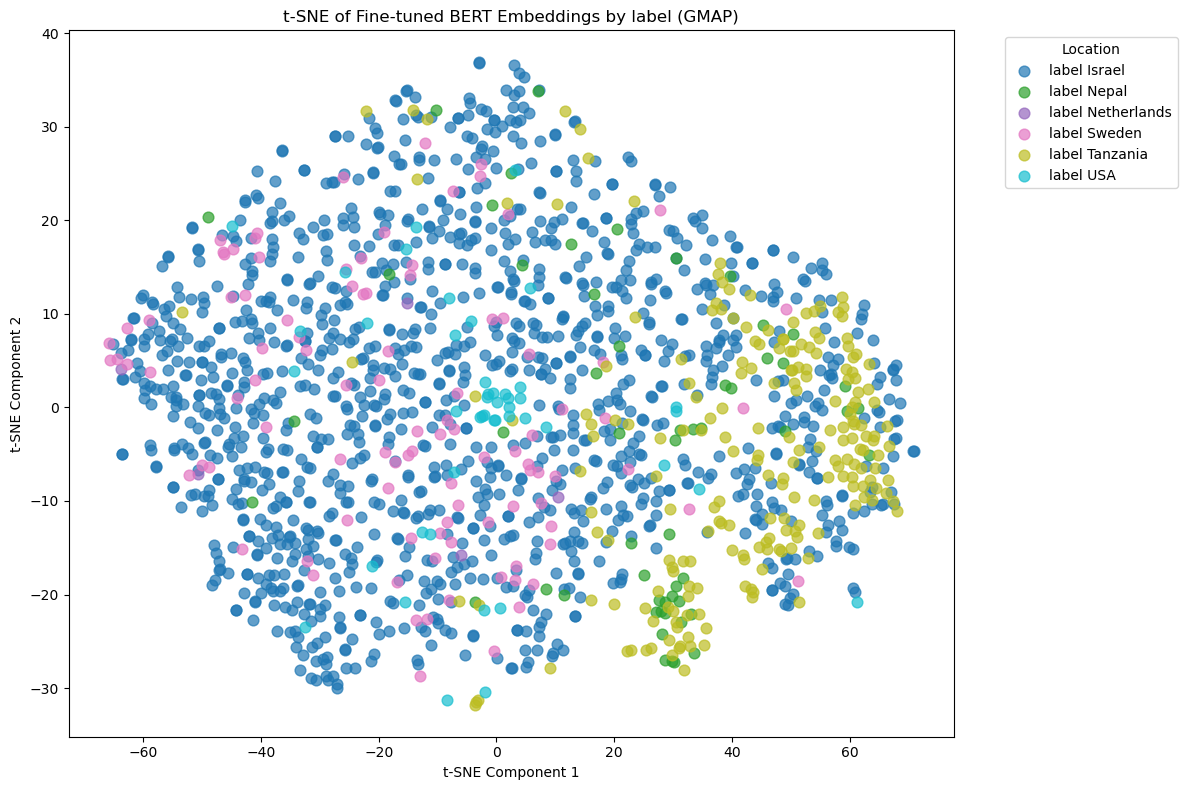

In [13]:
# tSNE of adult_gut train samples by location

data_file = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/sentences_with_labels/data_for_fine_tuning.tsv"
sentences, metadata = load_and_prepare_data(data_file, metadata_columns=['Filename', 'Location', 'Sample_type'])
output_dir = "/sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/Fine-tuning-data/"

mask = metadata["Sample_type"] == "adult_gut"
sentences = [s for s, keep in zip(sentences, mask) if keep]
metadata = metadata[mask].reset_index(drop=True)

model = AutoModelForMaskedLM.from_pretrained(f"{OUTPUT_DIR}/model")
tokenizer = AutoTokenizer.from_pretrained(f"{OUTPUT_DIR}/tokenizer")

embeddings = generate_and_save_embeddings(
    sentences, metadata, model, tokenizer, output_dir
)

tsne_results = run_tsne(
    embedding_file=f"{output_dir}/sample_embeddings.npy",
    label_file=f"{output_dir}/sample_metadata.csv",
    title='t-SNE of Fine-tuned BERT Embeddings by label (GMAP)',
    label_column='Location',
    output_file=f"{output_dir}/tsne_age_plot.png"
)

Loaded embeddings: (1679, 768)
Loaded labels: 1679   unique=['Israel' 'Nepal' 'Netherlands' 'Sweden' 'Tanzania' 'USA']
Running PCA …
Saved PCA plot to /sci/backup/morani/lab/Projects/Aluma/ANLP/Project/unsupervised_model/Fine-tuning-data//pca_age_plot.png


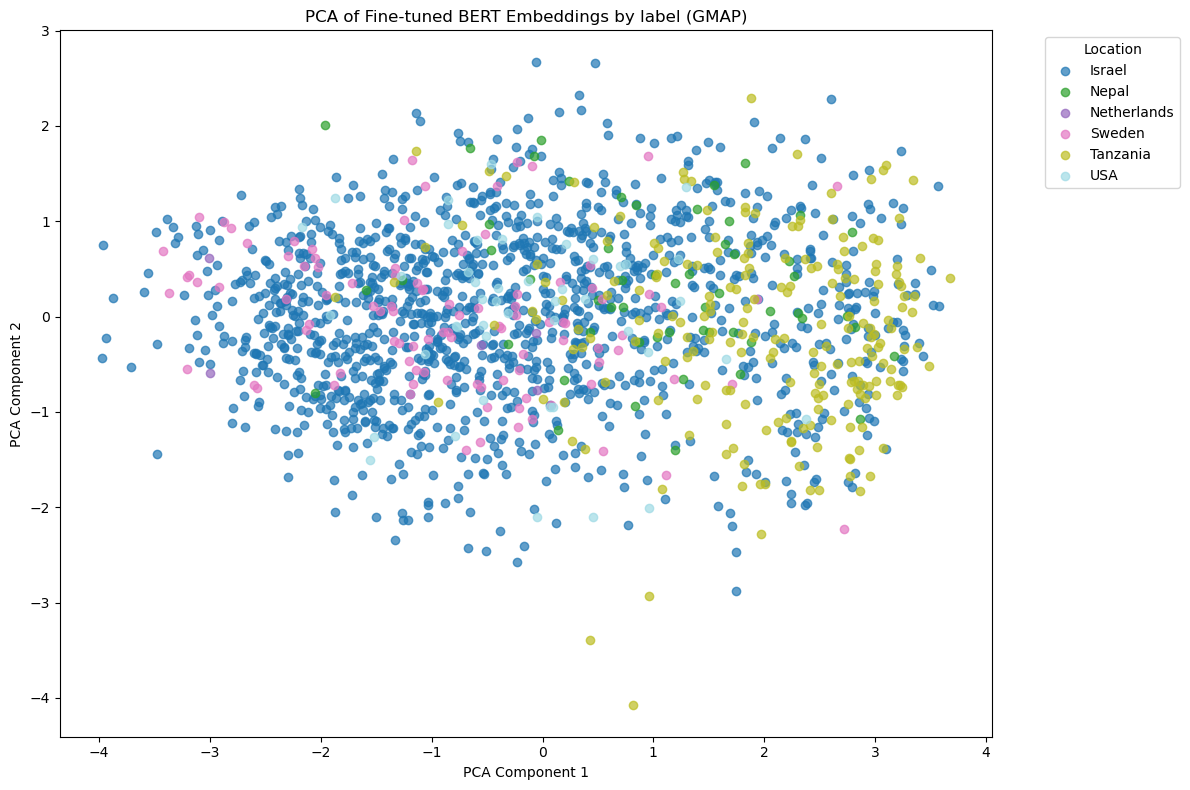

In [14]:
# ------------------------------------------------------------------
# 2-D PCA visualisation — API identical to run_tsne
# ------------------------------------------------------------------
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_pca(embedding_file, label_file, title,
            label_column='', output_file=None, n_components=2):
    """
    Project embeddings to 2-D with PCA and make a scatter plot
    coloured by `label_column`.

    Parameters
    ----------
    embedding_file : str   path to .npy of shape (N, D)
    label_file     : str   CSV with metadata / labels
    title          : str   figure title
    label_column   : str   column in CSV used for colouring
    output_file    : str or None – if given, PNG is saved
    n_components   : int   PCA target dimensionality (default 2)

    Returns
    -------
    pandas.DataFrame with PCA-1, PCA-2, label
    """
    # --- load data -------------------------------------------------------
    embeddings = np.load(embedding_file)
    print(f"Loaded embeddings: {embeddings.shape}")

    labels_df = pd.read_csv(label_file)
    labels = labels_df[label_column].values
    print(f"Loaded labels: {len(labels)}   unique={np.unique(labels)}")

    assert embeddings.shape[0] == len(labels), \
        "Mismatch between embeddings and labels count."

    # --- PCA -------------------------------------------------------------
    print("Running PCA …")
    pca = PCA(n_components=n_components, random_state=42)
    pca_result = pca.fit_transform(embeddings)

    pca_df = pd.DataFrame({
        'PCA-1': pca_result[:, 0],
        'PCA-2': pca_result[:, 1],
        'label': labels
    })

    # --- plotting --------------------------------------------------------
    plt.figure(figsize=(12, 8))

    if np.issubdtype(labels.dtype, np.number):
        scatter = plt.scatter(pca_df['PCA-1'], pca_df['PCA-2'],
                              c=pca_df['label'], cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label=label_column)
    else:
        # For categorical labels use tab20 & legend
        categories = np.unique(labels)
        cmap = plt.get_cmap('tab20', len(categories))
        for i, cat in enumerate(categories):
            idx = pca_df['label'] == cat
            plt.scatter(pca_df.loc[idx, 'PCA-1'],
                        pca_df.loc[idx, 'PCA-2'],
                        c=[cmap(i)], label=str(cat), alpha=0.7)
        plt.legend(title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved PCA plot to {output_file}")

    plt.show()
    return pca_df


# ------------------------------------------------------------------
# ▶︎ run it with the SAME paths & label column you used for t-SNE
# ------------------------------------------------------------------
pca_results = run_pca(
    embedding_file=f"{output_dir}/sample_embeddings.npy",
    label_file    =f"{output_dir}/sample_metadata.csv",
    title         ='PCA of Fine-tuned BERT Embeddings by label (GMAP)',
    label_column  ='Location',                                   # same as t-SNE
    output_file   =f"{output_dir}/pca_age_plot.png"    # new PNG name
)